In [1]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
from copy import deepcopy
from pathlib import Path
from gsat import GSAT, ExtractorMLP
from re_gsat import ReGSAT
from utils import get_data_loaders, get_model, set_seed, Criterion, init_metric_dict, load_checkpoint
from trainer import run_one_epoch, update_best_epoch_res, get_viz_idx, visualize_results
from datetime import datetime


In [27]:
dataset_name = 'ba_2motifs'
# dataset_name = 'mutag'
model_name = 'GIN'

# dataset_name = 'ogbg_molhiv'
# model_name = 'PNA'

method_name = 'GSAT'
cuda_id = 0
seed = 5
set_seed(seed)

In [28]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

if model_name == 'GIN':
    model_config = {'model_name': 'GIN', 'hidden_size': 64, 'n_layers': 2, 'dropout_p': 0.3, 'use_edge_attr': True}
else:
    assert model_name == 'PNA'
    model_config = {'model_name': 'PNA', 'hidden_size': 80, 'n_layers': 4, 'dropout_p': 0.3, 'use_edge_attr': False, 
                    'atom_encoder': True, 'aggregators': ['mean', 'min', 'max', 'std'], 'scalers': False}
    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (datetime.now().strftime("%m_%d_%Y-%H_%M_%S") + '-' + dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)


In [29]:
loaders, test_set, x_dim, edge_attr_dim, num_class, aux_info = get_data_loaders(data_dir, dataset_name, batch_size=128, random_state=seed,
                                                                                splits={'train': 0.8, 'valid': 0.1, 'test': 0.1}, 
                                                                                mutag_x=True if dataset_name == 'mutag' else False)
model_config['deg'] = aux_info['deg']

[INFO] Randomly split dataset!
[INFO] Calculating degree...


In [30]:
clf = get_model(x_dim, edge_attr_dim, num_class, aux_info['multi_label'], model_config, device)
extractor = ExtractorMLP(model_config['hidden_size'], learn_edge_att=False).to(device)
optimizer = torch.optim.Adam(list(extractor.parameters()) + list(clf.parameters()), lr=1e-3, weight_decay=3.0e-6)
criterion = Criterion(num_class, aux_info['multi_label'])
gsat = GSAT(clf, extractor, criterion, optimizer, learn_edge_att=False, final_r=0.7)

[INFO] Using multi_label: False


In [ ]:
metrics = {
      'train': {'att_auroc': [], 'clf_acc': [], 'clf_roc': [], 'avg_loss': []},
      'valid': {'att_auroc': [], 'clf_acc': [], 'clf_roc': [], 'avg_loss': []},
      'test': {'att_auroc': [], 'clf_acc': [], 'clf_roc': [], 'avg_loss': []}
      
}
for epoch in range(100):
    (train_att_auroc, 
    _, 
    train_clf_acc, 
    train_clf_roc, 
    train_avg_loss) = run_one_epoch(gsat, loaders['train'], epoch, 'train', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    (val_att_auroc, 
    _, 
    val_clf_acc, 
    val_clf_roc, 
    val_avg_loss) = run_one_epoch(gsat, loaders['valid'], epoch, 'valid', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    (test_att_auroc, 
    _, 
    test_clf_acc, 
    test_clf_roc, 
    test_avg_loss) = run_one_epoch(gsat, loaders['test'], epoch, 'test', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])

    metrics['train']['att_auroc'].append(train_att_auroc)
    metrics['train']['clf_acc'].append(train_clf_acc)
    metrics['train']['clf_roc'].append(train_clf_roc)
    metrics['train']['avg_loss'].append(train_avg_loss)
    metrics['valid']['att_auroc'].append(val_att_auroc)
    metrics['valid']['clf_acc'].append(val_clf_acc)
    metrics['valid']['clf_roc'].append(val_clf_roc)
    metrics['valid']['avg_loss'].append(val_avg_loss)
    metrics['test']['att_auroc'].append(test_att_auroc)
    metrics['test']['clf_acc'].append(test_clf_acc)
    metrics['test']['clf_roc'].append(test_clf_roc)
    metrics['test']['avg_loss'].append(test_avg_loss)


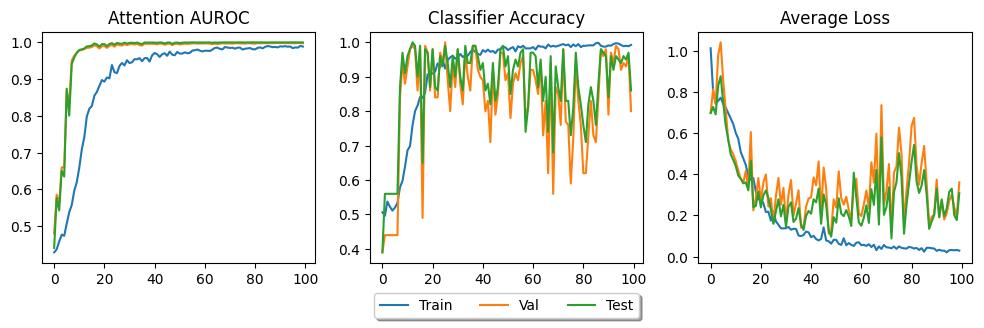

In [32]:
# Plot the results
# AUROC for attention in each epoch for the three datasets
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(metrics['train']['att_auroc'], label='Train')
ax[0].plot(metrics['valid']['att_auroc'], label='Val')
ax[0].plot(metrics['test']['att_auroc'], label='Test')
ax[0].set_title('Attention AUROC')

ax[1].plot(metrics['train']['clf_acc'], label='Train')
ax[1].plot(metrics['valid']['clf_acc'], label='Val')
ax[1].plot(metrics['test']['clf_acc'], label='Test')
ax[1].set_title('Classifier Accuracy')

# ax[2].plot(metrics['train']['clf_roc'], label='Train')
# ax[2].plot(metrics['valid']['clf_roc'], label='Val')
# ax[2].plot(metrics['test']['clf_roc'], label='Test')
# ax[2].set_ylabel('Classifier AUROC')

ax[2].plot(metrics['train']['avg_loss'], label='Train')
ax[2].plot(metrics['valid']['avg_loss'], label='Val')
ax[2].plot(metrics['test']['avg_loss'], label='Test')
ax[2].set_title('Average Loss')

# Put a common legend at the bottom of all the plots
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=3)
plt.show()

In [12]:
best_epoch = metric_dict['metric/best_clf_epoch']
load_checkpoint(gsat, model_dir, model_name=f'gsat_epoch_{best_epoch}', map_location=device)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 14.28it/s]


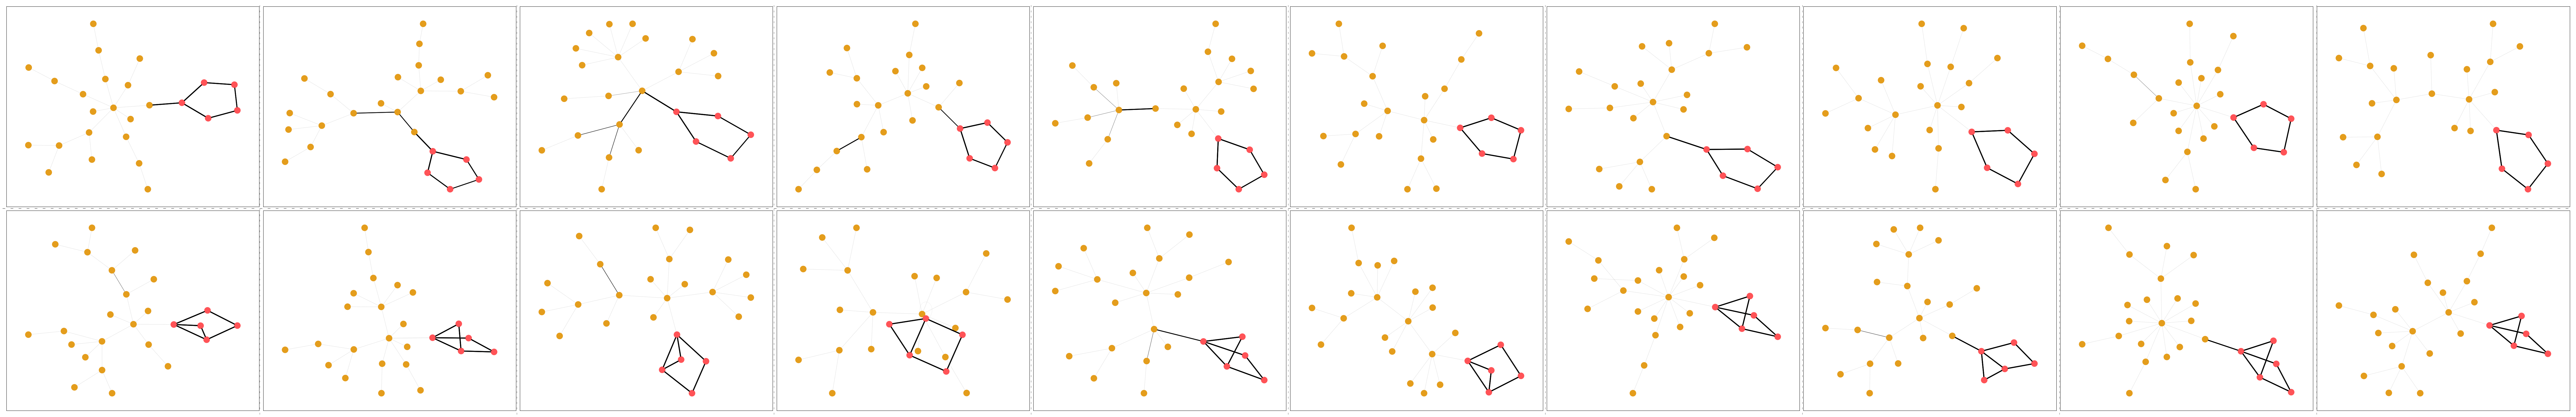

In [13]:
num_viz_samples = 10
assert aux_info['multi_label'] is False

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)
visualize_results(gsat, all_viz_set, test_set, num_viz_samples, dataset_name, model_config['use_edge_attr'])